In [ ]:
import os
import numpy as np
import cv2
import gc
import torch
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

try:
    from tensorflow.keras import backend as K
except:
    K = None

def temizle_colab_bellek():
    if K:
        print("→ TensorFlow oturumu temizleniyor...")
        K.clear_session()
    if torch.cuda.is_available():
        print("→ PyTorch GPU belleği temizleniyor...")
        torch.cuda.empty_cache()
    gc.collect()
    print("✅ RAM temizliği tamamlandı.")

temizle_colab_bellek()


→ TensorFlow oturumu temizleniyor...
→ PyTorch GPU belleği temizleniyor...
✅ RAM temizliği tamamlandı.


In [ ]:

base_dir = "/content/drive/MyDrive/dataset/breast_kanser_ayrilmis"
categories = ["kanser", "kanser_degil"]
image_size = (180, 180)


def load_images_and_labels(base_dir, categories, image_size):
    images, labels = [], []
    for category in categories:
        label = categories.index(category)
        path = os.path.join(base_dir, category)
        for fname in os.listdir(path):
            try:
                img_path = os.path.join(path, fname)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.resize(img, image_size)
                img = img / 255.0
                images.append(img)
                labels.append(label)
            except:
                continue
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(base_dir, categories, image_size)


In [ ]:

test_ratio = 0.2
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=test_ratio, stratify=labels, random_state=42)


from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))


aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
aug.fit(train_images)


In [ ]:


def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=2)
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=1))
    return focal_loss_fixed


input_shape = train_images[0].shape
num_classes = len(categories)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=focal_loss(gamma=2, alpha=0.5),
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_cnn_model_focal.h5", monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

history = model.fit(
    aug.flow(train_images, train_labels, batch_size=32),
    validation_data=(test_images, test_labels),
    epochs=50,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5547 - loss: 0.0893

78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.5547 - loss: 0.0893 - val_accuracy: 0.5620 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.5865 - loss: 0.0847 - val_accuracy: 0.5620 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.5587 - loss: 0.0862 - val_accuracy: 0.5620 - val_loss: 0.0857 - learning_rate: 0.0010
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.5618 - loss: 0.0860 - val_accuracy: 0.5620 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.5600 - loss: 0.0860 - val_accuracy: 0.5620 - val_loss: 0.0858 - learning_rate: 3.0000e-04
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.5695 - loss: 0.0854 - val_accuracy: 0.5620 - val_loss: 0.0858 - learning_rate: 3.0000e-04
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.5659 - loss: 0.085

78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.5795 - loss: 0.0842 - val_accuracy: 0.6006 - val_loss: 0.0825 - learning_rate: 3.0000e-04
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5630 - loss: 0.0837

78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy: 0.5630 - loss: 0.0837 - val_accuracy: 0.6023 - val_loss: 0.0825 - learning_rate: 3.0000e-04
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5844 - loss: 0.0827

78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.5843 - loss: 0.0827 - val_accuracy: 0.6119 - val_loss: 0.0837 - learning_rate: 3.0000e-04
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.5829 - loss: 0.0834 - val_accuracy: 0.5926 - val_loss: 0.0828 - learning_rate: 3.0000e-04
Epoch 13/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.5763 - loss: 0.0831 - val_accuracy: 0.6055 - val_loss: 0.0825 - learning_rate: 9.0000e-05
Epoch 14/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.5880 - loss: 0.0841 - val_accuracy: 0.5974 - val_loss: 0.0820 - learning_rate: 9.0000e-05
Epoch 15/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.5847 - loss: 0.0848 - val_accuracy: 0.6055 - val_loss: 0.0820 - learning_rate: 9.0000e-05
Epoch 16/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.5749 - loss: 0.0846 - val_accuracy: 0.6071 - val_loss: 0.0820 - learning_rate: 9.0000e-05
Epoch 17/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy:

78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.5769 - loss: 0.0836 - val_accuracy: 0.6296 - val_loss: 0.0820 - learning_rate: 9.0000e-05
Epoch 18/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.5722 - loss: 0.0833 - val_accuracy: 0.6167 - val_loss: 0.0818 - learning_rate: 2.7000e-05
Epoch 19/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.5963 - loss: 0.0833 - val_accuracy: 0.6151 - val_loss: 0.0818 - learning_rate: 2.7000e-05
Epoch 20/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.5745 - loss: 0.0840 - val_accuracy: 0.6151 - val_loss: 0.0818 - learning_rate: 2.7000e-05
Epoch 21/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.5835 - loss: 0.0831 - val_accuracy: 0.6039 - val_loss: 0.0818 - learning_rate: 2.7000e-05
Epoch 22/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.6014 - loss: 0.0831 - val_accuracy: 0.6087 - val_loss: 0.0818 - learning_rate: 8.1000e-06
Epoch 23/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy

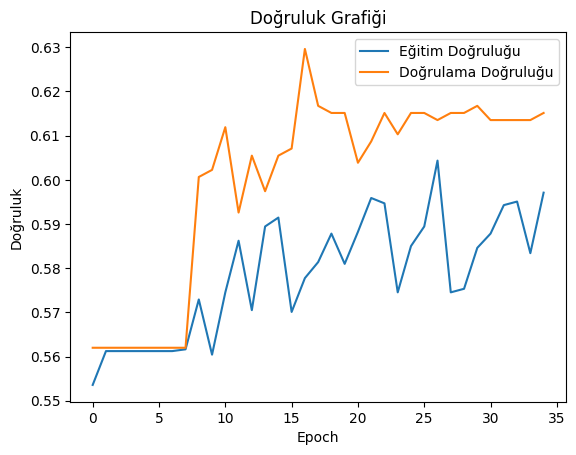

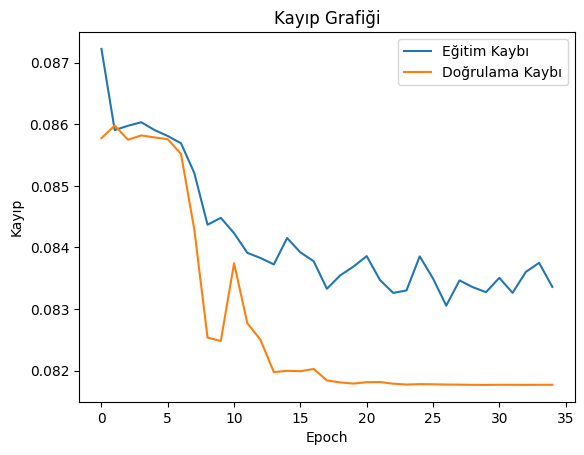

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [ ]:

plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Doğruluk'); plt.title("Doğruluk Grafiği"); plt.show()

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Kayıp'); plt.title("Kayıp Grafiği"); plt.show()


y_probs = model.predict(test_images)
y_pred = np.argmax(y_probs, axis=1)

In [ ]:
print("Sınıflandırma Raporu:\n", classification_report(test_labels, y_pred, target_names=categories))
print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))


Sınıflandırma Raporu:
               precision    recall  f1-score   support

      kanser       0.59      0.42      0.49       272
kanser_degil       0.63      0.77      0.69       349

    accuracy                           0.62       621
   macro avg       0.61      0.60      0.59       621
weighted avg       0.61      0.62      0.60       621

Confusion Matrix:
 [[115 157]
 [ 81 268]]


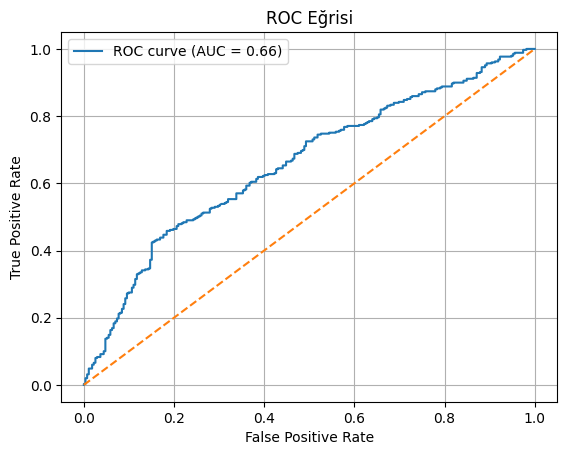

In [ ]:

y_true_binary = label_binarize(test_labels, classes=[0, 1])
y_score = y_probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
auc_score = roc_auc_score(y_true_binary, y_score)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend()
plt.grid()
plt.show()

In [ ]:

model.save("/content/drive/MyDrive/Colab Notebooks/models/meme_kanseri_0405_0.h5")